In [5]:
import rl
import gym
import gym_search

envs = gym.vector.make("Gaussian-S", num_envs=1)
map_agent = rl.agents.make("map", envs)
lstm_agent = rl.agents.make("baseline", envs)

def num_params(model, trainable=False):
    if trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

print(num_params(map_agent))
print(num_params(lstm_agent))

796223
963111


In [8]:
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator, STORE_EVERYTHING_SIZE_GUIDANCE

def load_tfevents_scalars(events, tag):
    event_acc = EventAccumulator(events, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    event_acc.Reload()
    scalars = event_acc.Scalars(tag)
    return pd.DataFrame(scalars)

events = load_tfevents_scalars("logs/gaussian-v0-ppo-baseline-1-2022-04-22T14:22:11/events.out.tfevents.1650630132.k2008779.1316391.0", "episode/length")

In [10]:
events.head()

,wall_time,step,value
0,1.650630e+09,6144,48.0
1,1.650630e+09,7552,59.0
2,1.650630e+09,10112,79.0
3,1.650630e+09,15488,121.0
4,1.650630e+09,16256,127.0


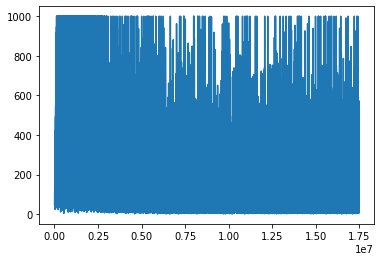

In [7]:
import matplotlib.pyplot as plt

steps, values = zip(*((event.step, event.value) for event in events))
plt.plot(steps, values)